In [1]:
import timeit
from datetime import timedelta
import math
import numpy as np
import pandas as pd
# from pandas_profiling import ProfileReport
# import lux # slows down dataframe processing
import matplotlib.pyplot as plt
%matplotlib inline
import joblib

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, KFold, HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, zero_one_loss, hamming_loss, classification_report, multilabel_confusion_matrix, \
                            ConfusionMatrixDisplay

np.set_printoptions(suppress=True) # do not print scientific notation

# Set some matplotlib style parameters
plt.style.use('seaborn')
plt.rcParams.update({'figure.facecolor' : 'white',
                     'figure.edgecolor' : 'white',
                     'axes.grid'        : True,
                     # 'axes.axisbelow'   : True,
                     'figure.autolayout': True # tight_layout
                    })

# Set some pandas options
pd.set_option('display.max_columns', None, # show x columns (None shows all)
              # 'display.max_rows', None,  # show x rows    (None shows all)
              'compute.use_numba', True)   # turn off for Lux

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [26]:
nb_name = 'full_solution' # for saving objects with joblib
seed = 42
rng = np.random.default_rng(seed)

n = secure_bits = 32        # rows
m = corrected_key_bits = 64 # columns
N_vec = 10000               # nº of corrected key vectors

## Functions

### Detect power consumption of basic gates

In [3]:
def get_product_power(mat, vec, gate_powers, noise_std=0.):
    '''Returns: array with the power consumed by the gates of each product.
    Set noise_std = 0 to eliminate noise.'''
    n, m = mat.shape
    count = [[] for _ in range(n)]
    for i in range(n):
        for j in range(m):
            idx = 2 * mat[i, j] + vec[j]
            count[i].extend(gate_powers[idx] + rng.normal(scale=noise_std, size=gate_powers[idx].size))
    return count # size = n * m * gate_powers[idx].size

In [4]:
def get_sum_power(mat, vec, gate_powers, noise_std=0.):
    '''Returns: array with the power consumed by the gates of each sum.
    Set noise_std = 0 to eliminate noise.'''
    n, m = mat.shape
    count = [[] for _ in range(n)]
    for i in range(n):
        result = 0
        for j in range(m):
            next_element = mat[i, j] * vec[j]
            idx = 2 * result + next_element
            count[i].extend(gate_powers[idx] + rng.normal(scale=noise_std, size=gate_powers[idx].size))
            result = (result + next_element) % 2
    return count # size = n * m * gate_powers[idx].size

In [5]:
# # TEST
# mat = np.asarray([[0, 1, 1, 0, 1],
#                   [1, 0, 1, 1, 1],
#                   [1, 1, 1, 1, 1],
#                   [0, 0, 0, 0, 0]])
# # vec = np.asarray([0, 0, 0, 0, 0])
# # vec = np.asarray([1, 1, 1, 1, 1])
# vec = np.asarray([1, 1, 1, 0, 0])
# power_products = np.asarray([[.1, 1.1], [.2, 1.2], [.3, 1.3], [.4, 1.4]])
# power_sums = np.asarray([[1.1, 2.1], [1.2, 2.2], [1.3, 2.3], [1.4, 2.4]])

# print(mat @ vec % 2, '\n')
# count = get_product_power(mat, vec, power_products, 0.01)
# print(np.around(count, 3), '\n')
# count = get_sum_power(mat, vec, power_sums, 0.01)
# print(np.around(count, 3))

### Class

In [5]:
# Detect if there are more 1s than 0s
# def More_1_than_0(mat, vec):
#     return np.sum(mat @ vec % 2) > secure_bits / 2

# Detect full solution
def Full_solution(mat, vec):
    return mat @ vec % 2

### Other

In [6]:
# Check if input & output vectors from sample are unique
def Check_uniqueness(mat, vec):
    res = []
    for i in range(len(vec)):
        res.append(mat @ vec[i] % 2)
    unique_in  = np.unique(vec, axis=0)
    unique_out = np.unique(res, axis=0)
    return unique_in.shape[0], unique_out.shape[0]

## Generate data

In [27]:
mat = rng.integers(2, size=(secure_bits,corrected_key_bits), dtype=np.int8)

mat.shape, mat

((32, 64),
 array([[1, 0, 1, ..., 1, 0, 1],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 0, 1, 0],
        [0, 1, 0, ..., 1, 1, 1]], dtype=int8))

In [28]:
vec = [rng.integers(2, size=corrected_key_bits, dtype=np.int8) for _ in range(N_vec)]

np.shape(vec), vec[0]

((10000, 64),
 array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0],
       dtype=int8))

In [29]:
unique_in, unique_out = Check_uniqueness(mat, vec)
print(f'{N_vec} inputs: {unique_in} unique inputs, {unique_out} unique solutions')

10000 inputs: 10000 unique inputs, 10000 unique solutions


Assumptions on power consumption (based on https://ieeexplore.ieee.org/document/6644863):
- NOT:
    - 0 - 6.73 pA
    - 1 - 7.45 pA
- 2-input NOR:
    - 00 - 13.50 pA
    - 01 - 12.80 pA
    - 10 - &nbsp; 7.93 pA
    - 11 - &nbsp; 5.93 pA
- 2-input NAND:
    - 00 - &nbsp; 5.79 pA
    - 01 - &nbsp; 7.00 pA
    - 10 - 11.77 pA
    - 11 - 14.91 pA

Writing our operations in the gates above:
- A\*B &nbsp;= AND(A, B)
= NOT(NAND(A, B))

- A+B = XOR(A, B)
= NOT(A<=>B)
= NOT(AND(A->B, B->A))
= NAND(A->B, B->A)
= NAND(OR(NOT(A), B), OR(NOT(B), A)) =  
&nbsp; &nbsp; &nbsp; &nbsp; = NAND(NOT(NOR(NOT(A), B)), NOT(NOR(NOT(B), A)))

Thus:
- 0\*0: &nbsp; &nbsp; 5.79 + 7.45 = 13.24 pA
- 0\*1: &nbsp; &nbsp; 7.00 + 7.45 = 14.45 pA
- 1\*0: &nbsp; 11.77 + 7.45 = 19.22 pA
- 1\*1: &nbsp; 14.91 + 6.73 = 21.64 pA


- 0+0: &nbsp; 6.73 + 6.73 + &nbsp; 7.93 + &nbsp; 7.93 + 6.73 + 6.73 + 14.91 = 57.69 pA
- 0+1: &nbsp; 6.73 + 7.45 + &nbsp; 5.93 + 13.50 + 6.73 + 7.45 + 11.77 = 59.56 pA
- 1+0: &nbsp; 7.45 + 6.73 + 13.50 + &nbsp; 5.93 + 7.45 + 6.73 + &nbsp; 7.00 = 54.79 pA
- 1+1: &nbsp; 7.45 + 7.45 + 12.80 + 12.80 + 6.73 + 6.73 + 14.91 = 68.87 pA

In [10]:
# Define power consumption for each gate & noise level
power_product_gates = np.asarray([[5.79, 7.45], [7., 7.45], [11.77, 7.45], [14.91, 6.73]]) # 0*0, 0*1, 1*0, 1*1
power_sum_gates = np.asarray([[6.73, 6.73, 7.93, 7.93, 6.73, 6.73, 14.91],  # '0+0' gates
                              [6.73, 7.45, 5.93, 13.5, 6.73, 7.45, 11.77],  # '0+1' gates
                              [7.45, 6.73, 13.5, 5.93, 7.45, 6.73, 7.],     # '1+0' gates
                              [7.45, 7.45, 12.8, 12.8, 6.73, 6.73, 14.91]]) # '1+1' gates
noise_std = 0.05 + 0.0 # article measurement precision + hacker device noise

In [11]:
# i = 0
# print('Products:\n', np.around(get_product_power(mat, vec[i], power_product_gates, noise_std), 3))
# print('Sums:\n', np.around(get_sum_power(mat, vec[i], power_sum_gates, noise_std), 3))

In [12]:
# print("Full solution")
# print("-------------")
# for i in range(10):
#     print(Full_solution(mat, vec[i]))

In [11]:
# Order data by time (row by row)
data = [[] for _ in range(N_vec)]
for i in range(N_vec):
    product_power = get_product_power(mat, vec[i], power_product_gates, noise_std)
    sum_power     = get_sum_power(mat, vec[i], power_sum_gates, noise_std)
    for j in range(n):
        data[i].extend(product_power[j])
        data[i].extend(sum_power[j])
    data[i].extend(Full_solution(mat, vec[i]))

data = np.asarray(data)
data.shape

(10000, 1160)

In [12]:
# Lower data sampling
sampling_interval = 10 # in gates
data_low_sampling = data[:, 0:-n:sampling_interval]
data_low_sampling = np.append(data_low_sampling, data[:, -n:], axis=1)

data_low_sampling.shape

(10000, 124)

In [13]:
# Create dataframe for plotting raw data
df = pd.DataFrame(data_low_sampling)
df.drop_duplicates(inplace=True, ignore_index=True)
# np.around(df, 3)

In [ ]:
# Plot full power consumption through time
y = df.iloc[0][:-n]
X = np.arange(len(y))

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
plt.ylim(y.min()*0.925, y.max()*1.075)
# plt.xticks(np.arange(0, len(y)+1, 250))
# plt.yticks(np.arange(6, 16.1, 2))

# Set labels
plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
plt.title('Total Power consumption', fontsize=14)

# plt.savefig(f'Results/Other/power_consumption_total_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
plt.show()

# Plot power consumption of one row through time
line_length = int(np.ceil(m * (power_product_gates.shape[1] + power_sum_gates.shape[1]) / sampling_interval))
X = np.arange(line_length)
y = df.iloc[0][:line_length]

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
# plt.ylim(y.min()*0.925, y.max()*1.075)
# plt.xticks(np.arange(0, line_length+1, 10))
# plt.yticks(np.arange(6, 16.1, 2))

# Set labels
plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
plt.title('Power consumption of one row', fontsize=14)

# plt.savefig(f'Results/Other/power_consumption_one_row_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
plt.show()

In [ ]:
# FULL RESOLUTION (1 gate) ----- # Plot full power consumption through time
y = df.iloc[0][:-n]
X = np.arange(len(y))

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
plt.ylim(y.min()*0.925, y.max()*1.075)
# plt.xticks(np.arange(0, len(y)+1, 1000))
# plt.yticks(np.arange(6, 16.1, 2))

# Set labels
plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
plt.title('Total Power consumption', fontsize=14)

# plt.savefig(f'Results/Other/power_consumption_total_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
plt.show()

# Plot power consumption of one row through time
line_length = m * (power_product_gates.shape[1] + power_sum_gates.shape[1])
X = np.arange(line_length)
y = df.iloc[0][:line_length]

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
# plt.ylim(y.min()*0.925, y.max()*1.075)
# plt.xticks(np.arange(0, line_length+1, 25))
# plt.yticks(np.arange(6, 16.1, 2))

# Set labels
plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
plt.title('Power consumption of one row', fontsize=14)

# plt.savefig(f'Results/Other/power_consumption_one_row_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
plt.show()

In [18]:
# # Drop columns with equal values (worthless with noise)
# def duplicate_columns(df):
#     groups = df.columns.to_series().groupby(df.dtypes).groups
#     dups = []
#     for t, v in groups.items():
#         dcols = df[v].to_dict(orient='list')
#         vs = list(dcols.values())
#         ks = list(dcols.keys())
#         for i in range(len(vs)):
#             for j in range(i+1, len(vs)):
#                 if vs[i] == vs[j]: 
#                     dups.append(ks[i])
#                     break
#     if dups: print('Duplicate columns:', *dups)
#     return dups

# df.drop(duplicate_columns(df), axis=1, inplace=True)
# np.around(df, 3)

In [19]:
# # Check some trends in data (turn off numba engine first)
# pd.set_option('compute.use_numba', False)
# df2 = df.copy()
# df2.intent = [90] # More_1_than_0
# display(df2)
# pd.set_option('compute.use_numba', True)

In [26]:
# # Generate pandas profiling report
# profile = ProfileReport(
#     df, title=f'Full_Solution Low_Sampling={sampling_interval}_Noisy_Power_per_Gate noise_std={noise_std} Dataset Report',
#     explorative=True)
# # profile.to_widgets()
# profile.to_file(f'Docs/Full_Solution_-_Low_Sampling={sampling_interval}_Noisy_Power_per_Gate_noisestd={noise_std}_report.html')

### Split data

- CV splitters: integer seed (so splits are the same & we can compare folds)

- Estimators: RandomState seed (so estimator is robust to randomness)

In [14]:
# Split data into training & test set
X = np.asarray(df.iloc[:, :-n], order='C')
y = np.asarray(df.iloc[:, -n:], order='C')
assert X.flags['C_CONTIGUOUS']
assert y.flags['C_CONTIGUOUS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print('1s in train set:', *np.around(y_train.mean(axis=0) * 100, 2),
      '\n1s in test set: ', *np.around(y_test.mean(axis=0) * 100, 2))
np.shape(X_train), np.shape(X_test)

1s in train set: 49.72 49.46 49.69 48.71 49.99 51.31 50.35 49.96 
1s in test set:  50.85 49.2 49.25 51.05 50.3 49.75 50.45 49.85


((8000, 116), (2000, 116))

In [ ]:
# Save test set
test_set = {'X_test': X_test,
            'y_test': y_test}
joblib.dump(test_set, f'Data/test_set_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib', compress=3)

In [ ]:
# Delete unused variables to free some memory
del df, data_low_sampling, X, y

## Classifiers

### Functions to train & test models

#### TuneGridSearchCV (very slow)

In [66]:
# Metric functions for grid search
def hamming_loss_scorer(model, X, y):
    '''Incorrectly-predicted bits'''
    y_pred = model.predict(X)
    return -hamming_loss(y, y_pred)

def zero_one_loss_scorer(model, X, y):
    '''Incorrectly-predicted keys'''
    y_pred = model.predict(X)
    return -zero_one_loss(y, y_pred)

In [67]:
# Get best metrics & parameters
def get_best_result(grid_search):
    lst_hamming_loss  = grid_search.cv_results_['mean_test_hamming_loss']
    lst_zero_one_loss = grid_search.cv_results_['mean_test_zero_one_loss']
    lst_acc           = grid_search.cv_results_['mean_test_subset_accuracy']
    best_hl, best_zol = 1., 1.

    for i, (hl, zol, acc) in enumerate(zip(lst_hamming_loss, lst_zero_one_loss, lst_acc)):
        if -hl < best_hl or (-hl == best_hl and -zol < best_zol):
            best_i   = i
            best_hl  = -hl
            best_zol = -zol
            best_acc = acc

    best_pars = grid_search.cv_results_['params'][best_i]
    print(f"Best pars: {best_pars}\n"
          f"Fewest incorrectly-predicted bits: {best_hl:6.2%} +- {grid_search.cv_results_['std_test_hamming_loss'][best_i]:6.3%}\n"
          f"Incorrectly-predicted keys:        {best_zol:6.2%} +- {grid_search.cv_results_['std_test_zero_one_loss'][best_i]:6.3%}\n"
          f"Subset accuracy:                   {best_acc:6.2%} +- {grid_search.cv_results_['std_test_subset_accuracy'][best_i]:6.3%}")
    return best_pars

In [70]:
from tune_sklearn import TuneGridSearchCV
from ray.tune.schedulers import ASHAScheduler

# Perform a grid search with k-fold cross validation & early stopping
def Grid_Search(model, param_grid, X_train, y_train, early_stopping=False, multi_target=False):
    if multi_target:
        model = MultiOutputClassifier(model, n_jobs=-1) # DOES NOT WORK WITH MultiOutputClassifier :(
    pipe    = Pipeline([('scaler', None), ('model', model)])
    cv      = KFold(5, shuffle=True, random_state=seed) # cannot use stratification for multilabel classification
    metrics = {'hamming_loss':    hamming_loss_scorer,
               'zero_one_loss':   zero_one_loss_scorer,
               'subset_accuracy': 'accuracy'}
    if early_stopping:
        max_iters = 5
        early_stopping = ASHAScheduler(max_t=max_iters, reduction_factor=2)
    else:
        max_iters = 1
        early_stopping = False

    grid_search = TuneGridSearchCV(pipe, param_grid, scoring=metrics, refit='hamming_loss', early_stopping=early_stopping,
                                   max_iters=max_iters, cv=cv, n_jobs=-1, use_gpu=False, verbose=1)

    start_time = timeit.default_timer()
    # with joblib.parallel_backend('multiprocessing', n_jobs=-1):
    grid_search.fit(X_train, y_train)
    delta_time = timedelta(seconds=round(timeit.default_timer()-start_time))

    # Get best metrics & parameters
    best_pars = get_best_result(grid_search)
    pipe.set_params(**best_pars)
    print(f'Executed in:                      {delta_time}')

    return pipe

In [42]:
# Remove ray-tune leftovers after training
! rm -rf /tmp/ray/
! rm -rf ~/ray_results

#### GridSearchCV

In [72]:
# Metric functions for grid search
def my_scorer(model, X, y):
    y_pred = model.predict(X)
    return {'hamming_loss':    -hamming_loss(y, y_pred),  # incorrectly-predicted bits
            'zero_one_loss':   -zero_one_loss(y, y_pred), # incorrectly-predicted keys
            'subset_accuracy': accuracy_score(y, y_pred)}

In [73]:
# Get best metrics & parameters
def get_best_result(cv_results_):
    lst_hamming_loss  = cv_results_['mean_test_hamming_loss']
    lst_zero_one_loss = cv_results_['mean_test_zero_one_loss']
    lst_acc           = cv_results_['mean_test_subset_accuracy']
    best_hl, best_zol = 1., 1.

    for i, (hl, zol, acc) in enumerate(zip(lst_hamming_loss, lst_zero_one_loss, lst_acc)):
        if -hl < best_hl or (-hl == best_hl and -zol < best_zol):
            best_i   = i
            best_hl  = -hl
            best_zol = -zol
            best_acc = acc

    best_pars = cv_results_['params'][best_i]
    print(f"\nBest pars: {best_pars}\n"
          f"Fewest incorrectly-predicted bits: {best_hl:6.2%} +- {cv_results_['std_test_hamming_loss'][best_i]:6.3%}\n"
          f"Incorrectly-predicted keys:        {best_zol:6.2%} +- {cv_results_['std_test_zero_one_loss'][best_i]:6.3%}\n"
          f"Subset accuracy:                   {best_acc:6.2%} +- {cv_results_['std_test_subset_accuracy'][best_i]:6.3%}")
    return best_i

In [74]:
from sklearn.model_selection import GridSearchCV

# Perform a grid search with k-fold cross validation
def Grid_Search(model, param_grid, X_train, y_train, multi_target=False):
    if multi_target:
        model = MultiOutputClassifier(model, n_jobs=-1)
    pipe        = Pipeline([('scaler', None), ('model', model)])
    cv          = KFold(5, shuffle=True, random_state=seed) # cannot use stratification for multilabel classification
    grid_search = GridSearchCV(pipe, param_grid, scoring=my_scorer, refit=get_best_result, cv=cv, n_jobs=-1, verbose=2)

    start_time = timeit.default_timer()
    with joblib.parallel_backend('multiprocessing', n_jobs=-1):
        grid_search.fit(X_train, y_train)
    delta_time = timedelta(seconds=round(timeit.default_timer()-start_time))
    print(f'Executed in:                      {delta_time}')

    return grid_search.best_estimator_

#### HalvingGridSearchCV

In [5]:
# Metric function for grid search
def hamming_loss_scorer(model, X, y):
    '''Incorrectly-predicted bits'''
    y_pred = model.predict(X)
    return -hamming_loss(y, y_pred)

In [6]:
# Perform a grid search with k-fold cross validation & successive halving
    # does not support multimetric scoring yet
def Grid_Search(model, param_grid, X_train, y_train, resource='n_samples', multi_target=False):
    if multi_target:
        model = MultiOutputClassifier(model, n_jobs=-1)
    pipe = Pipeline([('scaler', None), ('model', model)])
    cv   = KFold(3, shuffle=True, random_state=seed) # cannot use stratification for multilabel classification

    factor = 3
    if resource == 'n_samples':
        max_resources = len(X_train) # resources to use in last iteration
        grid_points   = sum([np.prod([len(v) for v in param_grid[i].values()]) for i in range(len(param_grid))])
        min_resources = int(max(max_resources//factor**round(math.log(max_resources/150, factor)), # use ~150 rows on first iteration
                                max_resources//factor**math.floor(math.log(grid_points, factor)))) # exhaust resources
    elif resource == 'n_estimators':
        min_resources = 'exhaust'
        if multi_target:
            resource      = 'model__estimator__' + resource
            max_resources = model.estimator.n_estimators
        else:
            resource      = 'model__' + resource
            max_resources = model.n_estimators

    grid_search = HalvingGridSearchCV(pipe, param_grid, scoring=hamming_loss_scorer, refit=True, factor=factor-1e-8,
                                      resource=resource, min_resources=min_resources, max_resources=max_resources+1, cv=cv,
                                      return_train_score=False, n_jobs=-1, random_state=seed, verbose=1) # factor-eps & max_resources+1 due to rounding errors

    start_time = timeit.default_timer()
    with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
        grid_search.fit(X_train, y_train)
    delta_time = timedelta(seconds=round(timeit.default_timer()-start_time))

    # Print best metric & parameters
    print(f"\nBest pars: {grid_search.best_params_}\n"
          f"Fewest incorrectly-predicted bits: {-grid_search.best_score_:6.2%} +- {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:6.3%}\n"
          f"Executed in:                      {delta_time}")

    return grid_search.best_estimator_

In [7]:
# Get prediction statistics
def get_statistics(model, X_test, y_test, model_name, prob=False):
    y_pred = model.predict(X_test)
    print(f'Incorrectly-predicted bits:  {hamming_loss(y_test, y_pred):6.2%}\n'  # (see description)
          f'Incorrectly-predicted keys:  {zero_one_loss(y_test, y_pred):6.2%}\n' # (see description)
          f'Subset accuracy on test set: {model.score(X_test, y_test):6.2%}')
    if prob:
        y_prob = model.predict_proba(X_test)
        print(f'Mean probability:            {np.mean(np.max(y_prob, axis=1)):6.2%}')

    confusion_matrices = multilabel_confusion_matrix(y_test, y_pred)
    # print('Confusion matrices: \n', confusion_matrices, '\n')
    print('\nReport:\n', classification_report(y_test, y_pred, digits=3))

    # Plot confusion matrices
    print('Confusion matrices:')
    n_rows, n_cols = 1 + (n - 1) // 5, 5
    plt.figure(figsize=(2.5 * n_cols, 2 * n_rows))
    for i in range(n_rows):
        for j in range(n_cols):
            idx = n_cols * i + j
            if idx == n: break

            ax = plt.subplot(n_rows, n_cols, idx+1)
            ConfusionMatrixDisplay(confusion_matrices[idx]).plot(values_format='d', cmap='Blues', colorbar=False, ax=ax)
            ax.set(xlabel='Predicted bit', ylabel='True bit')
            ax.grid(False)

    plt.savefig(f'Results/Other/confusion_matrices_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
    plt.show()

### Logistic regression

In [50]:
model = LogisticRegression(tol=1e-3, max_iter=1e4, n_jobs=-1, random_state=np.random.RandomState(seed), verbose=0)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler': [MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__estimator__solver':  ['saga', 'lbfgs'],
               'model__estimator__penalty': ['none']},
              {'scaler': [MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__estimator__solver':  ['saga'],
               'model__estimator__penalty': ['l1', 'l2'],
               'model__estimator__C':       np.logspace(2, -2, 5)},
              {'scaler': [MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__estimator__solver':  ['lbfgs'],
               'model__estimator__penalty': ['l2'],
               'model__estimator__C':       np.logspace(2, -2, 5)}]
pipe = Grid_Search(model, param_grid, X_train, y_train, multi_target=True) # GridSearchCV, HalvingGridSearchCV

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 296
max_resources_: 8001
aggressive_elimination: False
factor: 2.99999999
----------
iter: 0
n_candidates: 51
n_resources: 296
Fitting 3 folds for each of 51 candidates, totalling 153 fits
----------
iter: 1
n_candidates: 18
n_resources: 887
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 2
n_candidates: 7
n_resources: 2663
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 3
n_candidates: 3
n_resources: 7991
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best pars: {'model__estimator__C': 0.1, 'model__estimator__penalty': 'l1', 'model__estimator__solver': 'saga', 'scaler': StandardScaler()}
Fewest incorrectly-predicted bits:  0.47% +- 0.022%
Executed in:                      3:31:51


In [51]:
# Train with full training set
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    pipe.fit(X_train, y_train)

# Save model
model_name = 'LR1'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

In [52]:
# Get prediction statistics
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    get_statistics(pipe, X_test, y_test, model_name, prob=True)

Incorrectly-predicted bits:   0.38%
Incorrectly-predicted keys:  10.90%


In [53]:
model = SGDClassifier(loss='log', learning_rate='adaptive', eta0=1., tol=1e-3, max_iter=1e4, n_jobs=-1,
                      random_state=np.random.RandomState(seed), verbose=0)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler': [MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__estimator__penalty': ['l1', 'l2'],
               'model__estimator__alpha':   [0, *np.logspace(-5, 1, 7)],
               'model__estimator__eta0':    np.logspace(3, -3, 7)}]
pipe = Grid_Search(model, param_grid, X_train, y_train, multi_target=True) # GridSearchCV, HalvingGridSearchCV

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 2.99999999
----------
iter: 0
n_candidates: 336
n_resources: 98
Fitting 3 folds for each of 336 candidates, totalling 1008 fits
----------
iter: 1
n_candidates: 113
n_resources: 293
Fitting 3 folds for each of 113 candidates, totalling 339 fits
----------
iter: 2
n_candidates: 38
n_resources: 881
Fitting 3 folds for each of 38 candidates, totalling 114 fits
----------
iter: 3
n_candidates: 13
n_resources: 2645
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 4
n_candidates: 5
n_resources: 7937
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best pars: {'model__estimator__alpha': 0.01, 'model__estimator__eta0': 0.01, 'model__estimator__penalty': 'l1', 'scaler': StandardScaler()}
Fewest incorrectly-predicted bits:  0.80% +- 0.022%
Executed in:                      0:50:36


In [54]:
# Train with full training set
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    pipe.fit(X_train, y_train)

# Save model
model_name = 'LR2'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

In [55]:
# Get prediction statistics
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    get_statistics(pipe, X_test, y_test, model_name, prob=True)

Incorrectly-predicted bits:   0.75%
Incorrectly-predicted keys:  18.50%


### SVM

In [20]:
model = SVC(probability=False, tol=1e-3, max_iter=-1, cache_size=100000, random_state=np.random.RandomState(seed), verbose=False)

# Perform a grid search with k-fold cross validation
param_grid = [#{'scaler': [MinMaxScaler((-1, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
              #  'model__estimator__kernel': ['linear'],
              #  'model__estimator__C':      np.logspace(2, -2, 5)},
              {'scaler': [MinMaxScaler((-1, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__estimator__kernel': ['rbf'],
               'model__estimator__C':      np.logspace(2, -2, 5),
               'model__estimator__gamma':  ['scale', 'auto']},
              {'scaler': [MinMaxScaler((-1, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__estimator__kernel': ['poly'],
               'model__estimator__C':      np.logspace(2, -2, 5),
               'model__estimator__gamma':  ['scale', 'auto'],
               'model__estimator__degree': [3, 4],
               'model__estimator__coef0':  [-1, 0, 1]},
              # {'scaler': [MinMaxScaler((-1, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
              #  'model__estimator__kernel': ['sigmoid'],
              #  'model__estimator__C':      np.logspace(2, -2, 5),
              #  'model__estimator__gamma':  ['scale', 'auto'],
              #  'model__estimator__coef0':  [-1, 0, 1]}
             ]
pipe = Grid_Search(model, param_grid, X_train, y_train, multi_target=True) # GridSearchCV, HalvingGridSearchCV

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 2.99999999
----------
iter: 0
n_candidates: 210
n_resources: 98
Fitting 5 folds for each of 210 candidates, totalling 1050 fits
----------
iter: 1
n_candidates: 71
n_resources: 293
Fitting 5 folds for each of 71 candidates, totalling 355 fits
----------
iter: 2
n_candidates: 24
n_resources: 881
Fitting 5 folds for each of 24 candidates, totalling 120 fits
----------
iter: 3
n_candidates: 9
n_resources: 2645
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 4
n_candidates: 4
n_resources: 7937
Fitting 5 folds for each of 4 candidates, totalling 20 fits


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/v082327/.local/lib/python3.6/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 638, in get
    self.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 635, in wait
    self._event.wait(timeout)
  File "/usr/lib/python3.6/threading.py", line 551, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/v082327/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-f254c377ce2b>", line 23, in <module>
    pipe = Grid_Search(model, param_grid, X_train, y_train, multi_target=True) #

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Train with full training set
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    pipe.fit(X_train, y_train)

# Save model
model_name = 'SVM'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

In [ ]:
# Get prediction statistics
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    get_statistics(pipe, X_test, y_test, model_name)

In [ ]:
model = LinearSVC(tol=1e-3, max_iter=1e4, random_state=np.random.RandomState(seed), verbose=0)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler': [MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__estimator__penalty': ['l2'],
               'model__estimator__loss':    ['hinge', 'squared_hinge'],
               'model__estimator__dual':    [True],
               'model__estimator__C':       np.logspace(2, -2, 5)},
              {'scaler': [MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__estimator__penalty': ['l1', 'l2'],
               'model__estimator__loss':    ['squared_hinge'],
               'model__estimator__dual':    [False],
               'model__estimator__C':       np.logspace(2, -2, 5)}]
pipe = Grid_Search(model, param_grid, X_train, y_train, multi_target=True) # GridSearchCV, HalvingGridSearchCV

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 296
max_resources_: 8001
aggressive_elimination: False
factor: 2.99999999
----------
iter: 0
n_candidates: 30
n_resources: 296
Fitting 3 folds for each of 30 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 11
n_resources: 887
Fitting 3 folds for each of 11 candidates, totalling 33 fits
----------
iter: 2
n_candidates: 4
n_resources: 2663
Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [ ]:
# Train with full training set
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    pipe.fit(X_train, y_train)

# Save model
model_name = 'SVM_linear1'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

In [ ]:
# Get prediction statistics
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    get_statistics(pipe, X_test, y_test, model_name)

In [39]:
model = SGDClassifier(loss='hinge', learning_rate='adaptive', eta0=1., tol=1e-3, max_iter=1e4, n_jobs=-1,
                      random_state=np.random.RandomState(seed), verbose=0)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler': [MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__estimator__penalty': ['l1', 'l2'],
               'model__estimator__alpha':   [0, *np.logspace(-5, 1, 7)],
               'model__estimator__eta0':    np.logspace(3, -3, 7)}]
pipe = Grid_Search(model, param_grid, X_train, y_train, multi_target=True) # GridSearchCV, HalvingGridSearchCV

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 448
n_resources: 98
Fitting 5 folds for each of 448 candidates, totalling 2240 fits


/home/v082327/.local/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/v082327/.local/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/v082327/.local/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/v082327/.local/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/v082327/.l

----------
iter: 1
n_candidates: 150
n_resources: 294
Fitting 5 folds for each of 150 candidates, totalling 750 fits
----------
iter: 2
n_candidates: 50
n_resources: 882
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------
iter: 3
n_candidates: 17
n_resources: 2646
Fitting 5 folds for each of 17 candidates, totalling 85 fits
----------
iter: 4
n_candidates: 6
n_resources: 7938
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best pars: {'model__estimator__alpha': 0.01, 'model__estimator__eta0': 0.001, 'model__estimator__penalty': 'l1', 'scaler': MinMaxScaler()}
Fewest incorrectly-predicted bits: 45.48% +- 0.624%
Executed in:                      0:02:10


In [40]:
# Train with full training set
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    pipe.fit(X_train, y_train)

# Save model
model_name = 'SVM_linear2'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Incorrectly-predicted bits:  45.26%
Incorrectly-predicted keys:  100.00%
Subset accuracy on test set:  0.00%

Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000       962
           1      0.509     1.000     0.675      1019
           2      0.000     0.000     0.000       965
           3      1.000     1.000     1.000      1012
           4      0.000     0.000     0.000      1006
           5      0.484     1.000     0.652       968
           6      0.476     1.000     0.645       952
           7      0.000     0.000     0.000      1010
           8      1.000     0.516     0.681      1011
           9      0.489     1.000     0.657       979
          10      0.470     0.249     0.326       959
          11      0.494     0.607     0.544      1004
          12      0.000     0.000     0.000       990
          13      0.507     1.000     0.673      1015
          14      0.515     1.000     0.680      1030
          15    

/home/v082327/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


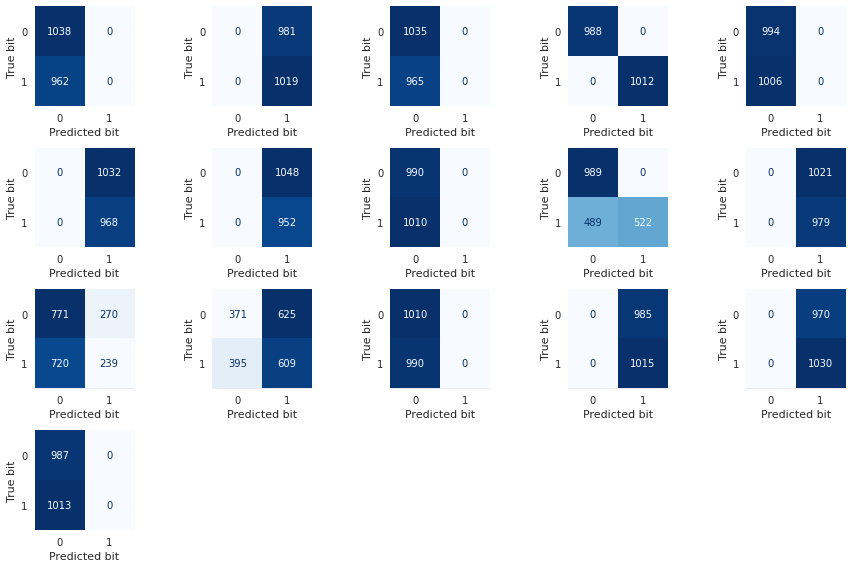

In [41]:
# Get prediction statistics
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    get_statistics(pipe, X_test, y_test, model_name)

### KNN

In [100]:
# KNeighborsClassifier supports multilabel classification
model = KNeighborsClassifier(n_jobs=-1)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler':             [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__n_neighbors': np.arange(1, 22, 2), # odd nº
               'model__weights':     ['uniform', 'distance'],
               'model__metric':      ['manhattan', 'euclidean', 'chebyshev']}]
pipe = Grid_Search(model, param_grid, X_train, y_train) # TuneGridSearchCV, GridSearchCV, HalvingGridSearchCV

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 2.99999999
----------
iter: 0
n_candidates: 264
n_resources: 98
Fitting 3 folds for each of 264 candidates, totalling 792 fits
----------
iter: 1
n_candidates: 89
n_resources: 293
Fitting 3 folds for each of 89 candidates, totalling 267 fits
----------
iter: 2
n_candidates: 30
n_resources: 881
Fitting 3 folds for each of 30 candidates, totalling 90 fits
----------
iter: 3
n_candidates: 11
n_resources: 2645
Fitting 3 folds for each of 11 candidates, totalling 33 fits
----------
iter: 4
n_candidates: 4
n_resources: 7937
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best pars: {'model__metric': 'euclidean', 'model__n_neighbors': 21, 'model__weights': 'distance', 'scaler': None}
Fewest incorrectly-predicted bits: 44.43% +- 0.098%
Executed in:                      0:04:13


In [101]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'KNN'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

In [102]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name, prob=True)

Incorrectly-predicted bits:  44.18%
Incorrectly-predicted keys:  100.00%


### Naïve Bayes

#### Gaussian NB

In [19]:
model = GaussianNB()

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler': [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__estimator__var_smoothing': [0, *np.logspace(-10, 5, 16)]}]
pipe = Grid_Search(model, param_grid, X_train, y_train, multi_target=True) # GridSearchCV, HalvingGridSearchCV

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 296
max_resources_: 8001
aggressive_elimination: False
factor: 2.99999999
----------
iter: 0
n_candidates: 68
n_resources: 296
Fitting 3 folds for each of 68 candidates, totalling 204 fits
----------
iter: 1
n_candidates: 23
n_resources: 887
Fitting 3 folds for each of 23 candidates, totalling 69 fits
----------
iter: 2
n_candidates: 8
n_resources: 2663
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 7991
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best pars: {'model__estimator__var_smoothing': 1e-08, 'scaler': None}
Fewest incorrectly-predicted bits: 13.15% +- 0.142%
Executed in:                      0:08:38


In [20]:
# Train with full training set
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    pipe.fit(X_train, y_train)

# Save model
model_name = 'NB_gaussian'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

In [21]:
# Get prediction statistics
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    get_statistics(pipe, X_test, y_test, model_name, prob=True)

Incorrectly-predicted bits:  11.92%
Incorrectly-predicted keys:  98.10%


#### Multinomial NB

In [22]:
model = MultinomialNB() # does not work with negative values

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler':                      [None, MinMaxScaler((0, 1))],
               'model__estimator__alpha':     np.logspace(-10, 5, 16),
               'model__estimator__fit_prior': [False, True]}]
pipe = Grid_Search(model, param_grid, X_train, y_train, multi_target=True) # GridSearchCV, HalvingGridSearchCV

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 296
max_resources_: 8001
aggressive_elimination: False
factor: 2.99999999
----------
iter: 0
n_candidates: 64
n_resources: 296
Fitting 3 folds for each of 64 candidates, totalling 192 fits
----------
iter: 1
n_candidates: 22
n_resources: 887
Fitting 3 folds for each of 22 candidates, totalling 66 fits
----------
iter: 2
n_candidates: 8
n_resources: 2663
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 7991
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best pars: {'model__estimator__alpha': 0.1, 'model__estimator__fit_prior': True, 'scaler': None}
Fewest incorrectly-predicted bits: 30.73% +- 0.184%
Executed in:                      0:02:15


In [23]:
# Train with full training set
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    pipe.fit(X_train, y_train)

# Save model
model_name = 'NB_multi'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

model = pipe[1].estimators_[0]
model.n_features_in_#, model.feature_count_

18432

In [24]:
# Get prediction statistics
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    get_statistics(pipe, X_test, y_test, model_name, prob=True)

Incorrectly-predicted bits:  28.39%
Incorrectly-predicted keys:  100.00%


#### Categorical NB

In [ ]:
model = CategoricalNB() # does not work with negative values

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler':                           [None], #MinMaxScaler((0, 1))],
               'model__estimator__alpha':          np.logspace(-5, 3, 9),
               'model__estimator__fit_prior':      [True, False],
               # 'model__estimator__min_categories': [*np.arange(int(0.1*N_vec), 19, -20), None]}]
               'model__estimator__min_categories': [*np.arange(int(0.1*N_vec), 99, -100), 20]}]
pipe = Grid_Search(model, param_grid, X_train, y_train, multi_target=True) # GridSearchCV, HalvingGridSearchCV

In [ ]:
# Train with full training set
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    pipe.fit(X_train, y_train)

# Save model
model_name = 'NB_cat'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

model = pipe[1].estimators_[0]
model.n_features_in_, model.n_categories_

In [ ]:
# Get prediction statistics
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    get_statistics(pipe, X_test, y_test, model_name, prob=True)

### Decision tree

In [18]:
best = None, 100, 100
for i in range(10):
    print('\n----------', i, '----------')
    model = DecisionTreeClassifier(random_state=np.random.RandomState(seed+i))

    # Perform a grid search with k-fold cross validation
    param_grid = [{'scaler': [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
                   'model__criterion':             ['gini', 'entropy'],
                   'model__max_depth':             [5, 10, 20, None],
                   'model__max_features':          [0.1, 0.3, 0.5, None],
                   # 'model__max_leaf_nodes':      range(2, 21),
                   'model__min_impurity_decrease': [*np.logspace(-2, -6, 5), 0]}]
    pipe = Grid_Search(model, param_grid, X_train, y_train) # TuneGridSearchCV, GridSearchCV, HalvingGridSearchCV
    pipe.fit(X_train, y_train)
    
    y_pred   = pipe.predict(X_test)
    hamming  = hamming_loss(y_test, y_pred)
    zero_one = zero_one_loss(y_test, y_pred)
    if hamming < best[1]: best = i, hamming, zero_one
    del pipe, model, param_grid

print(f'\nSeed: {seed+best[0]}\n'
      f'Incorrectly-predicted bits: {best[1]:6.2%}\n'
      f'Incorrectly-predicted keys: {best[2]:6.2%}')


---------- 0 ----------
n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 2.99999999
----------
iter: 0
n_candidates: 768
n_resources: 98
Fitting 3 folds for each of 768 candidates, totalling 2304 fits


KeyboardInterrupt: 

In [56]:
# DecisionTreeClassifier supports multilabel classification
model = DecisionTreeClassifier(random_state=np.random.RandomState(seed))

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler': [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__criterion':             ['gini', 'entropy'],
               'model__max_depth':             [5, 10, 20, None],
               'model__max_features':          [0.1, 0.3, 0.5, None],
               # 'model__max_leaf_nodes':      range(2, 21),
               'model__min_impurity_decrease': [*np.logspace(-2, -6, 5), 0]}]
pipe = Grid_Search(model, param_grid, X_train, y_train) # TuneGridSearchCV, GridSearchCV, HalvingGridSearchCV

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 768
n_resources: 98
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
----------
iter: 1
n_candidates: 256
n_resources: 294
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
----------
iter: 2
n_candidates: 86
n_resources: 882
Fitting 5 folds for each of 86 candidates, totalling 430 fits
----------
iter: 3
n_candidates: 29
n_resources: 2646
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 7938
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best pars: {'model__criterion': 'gini', 'model__max_depth': 20, 'model__max_features': 0.5, 'model__min_impurity_decrease': 1e-06, 'scaler': StandardScaler()}
Fewest incorrectly-predicted bits: 23.88% +- 0.328%
Executed in:                      0:01:34


In [44]:
# # Fine-tune min_impurity_decrease hyperparameter
# if pipe[1].min_impurity_decrease != 0.:
#     # Perform a grid search with k-fold cross validation
#     param_grid = [{'scaler':                       [pipe[0]],
#                    'model__min_impurity_decrease': pipe[1].min_impurity_decrease*np.asarray([0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8])}]
#     pipe = Grid_Search(pipe[1], param_grid, X_train, y_train) # TuneGridSearchCV, GridSearchCV, HalvingGridSearchCV

In [277]:
# # Fine-tune max_depth hyperparameter
# if pipe[1].max_depth != None:
#     # Perform a grid search with k-fold cross validation
#     param_grid = [{'scaler':           [pipe[0]],
#                    'model__max_depth': pipe[1].max_depth+np.arange(-4, 5)}]
#     pipe = Grid_Search(pipe[1], param_grid, X_train, y_train) # TuneGridSearchCV, GridSearchCV, HalvingGridSearchCV

In [57]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'DT'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

pipe[1].get_depth(), pipe[1].get_n_leaves()

(19, 7704)

Incorrectly-predicted bits:  22.38%
Incorrectly-predicted keys:  99.05%
Subset accuracy on test set:  0.95%
Mean probability:            100.00%

Report:
               precision    recall  f1-score   support

           0      0.547     0.604     0.574       962
           1      0.959     0.965     0.962      1019
           2      0.582     0.582     0.582       965
           3      1.000     1.000     1.000      1012
           4      0.604     0.596     0.600      1006
           5      0.541     0.538     0.540       968
           6      0.997     0.995     0.996       952
           7      0.580     0.559     0.570      1010
           8      0.957     0.961     0.959      1011
           9      0.598     0.621     0.609       979
          10      0.997     0.992     0.994       959
          11      0.977     0.968     0.972      1004
          12      0.931     0.928     0.930       990
          13      0.559     0.551     0.555      1015
          14      0.993     0.990 

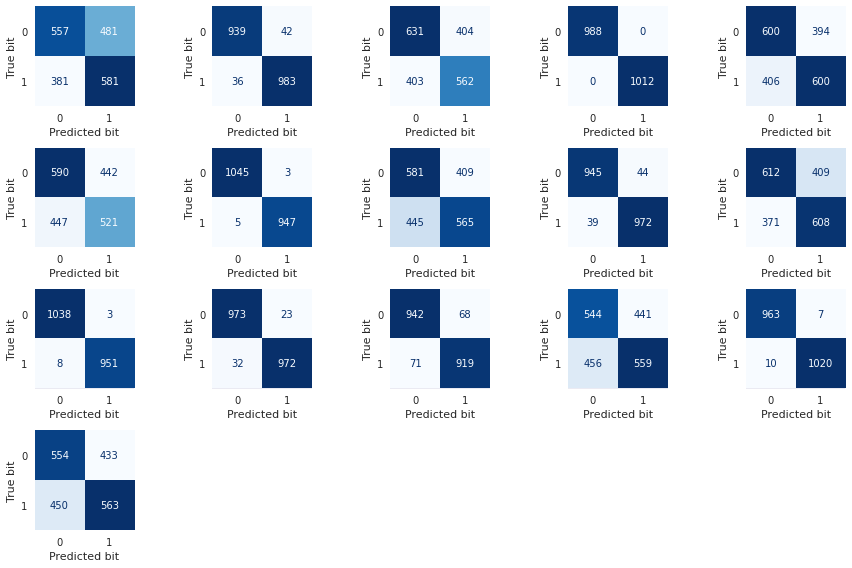

In [58]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name, prob=True)

In [155]:
# # Draw tree
# from sklearn.tree import export_graphviz
# import graphviz

# dot_data = export_graphviz(pipe[1], filled=True, rounded=True, special_characters=True)
#                            # feature_names=df.columns[:-n], class_names=['0','1']
# graph = graphviz.Source(dot_data)
# graph.render(f'Results/Other/DT_{nb_name}_low_sampling={sampling_interval}_noisy_power_per_gate_noisestd={noise_std}', cleanup=True)
# graph

### Random forest

In [35]:
# RandomForestClassifier supports multilabel classification
model = RandomForestClassifier(n_estimators=243, n_jobs=-1, random_state=np.random.RandomState(seed), verbose=0)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler': [MinMaxScaler((0, 1))], #[None, StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__criterion':             ['gini', 'entropy'],
               'model__max_depth':             [5, None],
               'model__max_features':          [0.1, 0.5, None],
               # 'model__max_leaf_nodes':      range(2, 21),
               'model__min_impurity_decrease': np.logspace(-3, -5, 2)}]
# pipe = Grid_Search(model, param_grid, X_train, y_train, early_stopping=True) # TuneGridSearchCV
# pipe = Grid_Search(model, param_grid, X_train, y_train) # GridSearchCV
pipe = Grid_Search(model, param_grid, X_train, y_train, resource='n_estimators') # HalvingGridSearchCV

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 11.0
max_resources_: 101
aggressive_elimination: False
factor: 2.99999999
----------
iter: 0
n_candidates: 24
n_resources: 11
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 1
n_candidates: 9
n_resources: 32
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 2
n_candidates: 4
n_resources: 98
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best pars: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 0.5, 'model__min_impurity_decrease': 0.001, 'scaler': MinMaxScaler(), 'model__n_estimators': 98}
Fewest incorrectly-predicted bits: 28.09% +- 0.066%
Executed in:                      17:57:23


In [36]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'RF'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

In [37]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name, prob=True)

Incorrectly-predicted bits:  28.23%
Incorrectly-predicted keys:  100.00%
Subset accuracy on test set:  0.00%


### Gradient-boosting

In [72]:
model = GradientBoostingClassifier(n_estimators=243, random_state=np.random.RandomState(seed), verbose=0)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler': [MinMaxScaler((0, 1))], #[None, StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__estimator__loss':                  ['deviance', 'exponential'],
               'model__estimator__learning_rate':         [*np.logspace(-2, -1, 2), 0.9],
               'model__estimator__subsample':             [0.5, 1],
               'model__estimator__criterion':             ['friedman_mse'], #'mse'],
               'model__estimator__max_depth':             [5, None],
               'model__estimator__max_features':          [0.1, 0.5, None],
               # 'model__estimator__max_leaf_nodes':      range(2, 21),
               'model__estimator__min_impurity_decrease': np.logspace(-3, -5, 2)}]
# pipe = Grid_Search(model, param_grid, X_train, y_train, multi_target=True) # GridSearchCV
pipe = Grid_Search(model, param_grid, X_train, y_train, resource='n_estimators', multi_target=True) # HalvingGridSearchCV

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 1
max_resources_: 244
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 576
n_resources: 1
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
----------
iter: 1
n_candidates: 192
n_resources: 3
Fitting 5 folds for each of 192 candidates, totalling 960 fits


Process ForkPoolWorker-1033:
Process ForkPoolWorker-1027:
Process ForkPoolWorker-1028:
Process ForkPoolWorker-1025:
Process ForkPoolWorker-1026:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258

KeyboardInterrupt: 

KeyboardInterrupt


In [ ]:
# Train with full training set
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    pipe.fit(X_train, y_train)

# Save model
model_name = 'GB'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

In [ ]:
# Get prediction statistics
with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
    get_statistics(pipe, X_test, y_test, model_name, prob=True)